In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

2022-11-30 13:40:04.868943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 13:40:11.550048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 13:40:11.550075: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-30 13:40:12.477125: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 13:40:22.487305: W tensorflow/stream_executor/platform/de

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


2022-11-30 13:40:30.092787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 13:40:30.093345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 13:40:30.093534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-30 13:40:30.093650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-30 13:40:30.093751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dir = "cell_images/train/"
test_dir = "cell_images/test/"

train_dataset = image_dataset_from_directory(
                train_dir,
                validation_split = 0.2,
                labels = "inferred",
                subset = "training",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = True
                )

val_dataset = image_dataset_from_directory(
                train_dir,
                validation_split = 0.2,
                labels = "inferred",
                subset = "validation",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = True
                )

test_dataset = image_dataset_from_directory(
                test_dir,
                labels = "inferred",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = True
                )

Found 24958 files belonging to 2 classes.
Using 19967 files for training.


2022-11-30 13:40:35.704579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 24958 files belonging to 2 classes.
Using 4991 files for validation.
Found 2600 files belonging to 2 classes.


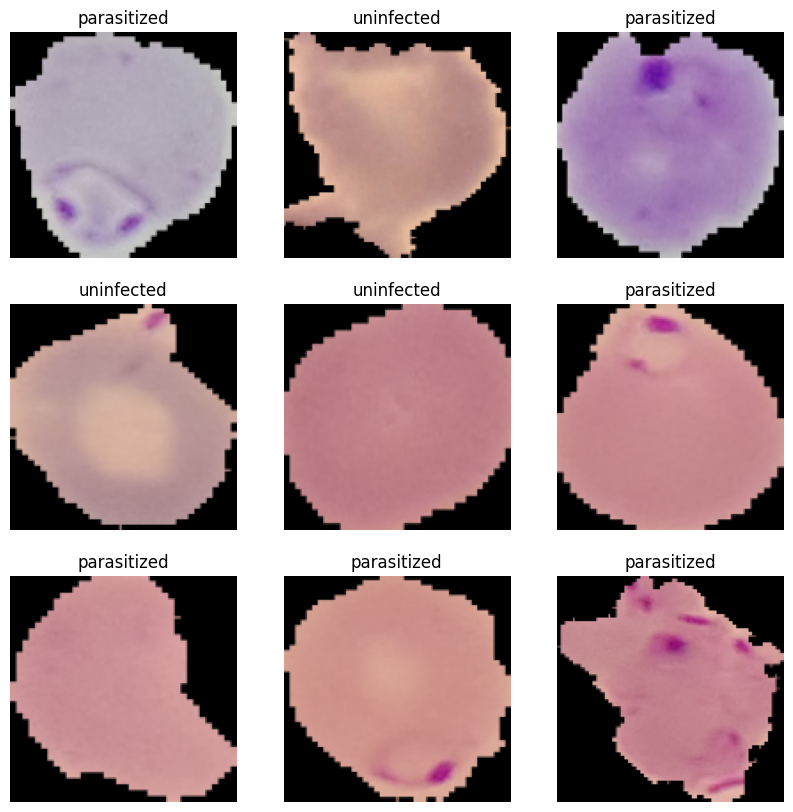

In [4]:
import matplotlib.pyplot as plt
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# Model hyperparameters
num_classes = 2
input_shape = (128, 128, 3)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = True


In [6]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [7]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.fit(train_dataset, validation_data=val_dataset, epochs= epochs)


Epoch 1/40


2022-11-30 12:35:36.491947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-30 12:35:43.976369: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 12:35:43.977379: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 12:35:43.977435: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-30 12:35:43.978279: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 12:35:43.978388: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-30 12:35:50.056928:

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_12' defined at (most recent call last):
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10607/2417636226.py", line 2, in <module>
      model.fit(train_dataset, validation_data=val_dataset, epochs= epochs)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/wph/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_12'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_12}}]] [Op:__inference_train_function_1996]

In [112]:
if save:
    model.save("models/cells/model40")

INFO:tensorflow:Assets written to: models/cells/model40\assets


INFO:tensorflow:Assets written to: models/cells/model40\assets


In [4]:
model = tf.keras.models.load_model("models/cells/model40")

In [5]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['parasitized', 'uninfected']

score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.25642091035842896
Test accuracy: 0.9503846168518066


In [6]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(test_dataset)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('parasitized', 0), ('uninfected', 1)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('parasitized', 0), ('uninfected', 1)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


41/41 [==============================] - 12s 284ms/step


Dropdown(description='True Label:', options=(('parasitized', 0), ('uninfected', 1)), value=0)

Dropdown(description='Predicted Label:', options=(('parasitized', 0), ('uninfected', 1)), value=0)

In [7]:
predicted_classes = predicted_classes[:64]
predicted_classes.shape

(64,)

In [8]:
for images, labels in test_dataset.take(1):
    img_batch = images.numpy().astype('uint8')
    label_batch = labels.numpy()


In [9]:
x = test_dataset.unbatch()
images = np.array(list(x.map(lambda x, y: x)))
labels = np.array(list(x.map(lambda x, y: y)))

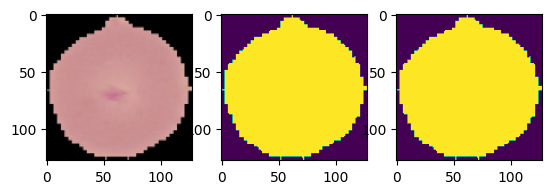

In [10]:
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from PIL import Image
import cv2
img = images[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
thresh = threshold_otsu(img_gray)
bw = img_gray > thresh
label_img = label(bw)
fig, ax = plt.subplots(1,3)
ax[0].imshow(img.astype('uint8'))
ax[1].imshow(bw)
ax[2].imshow(label_img)


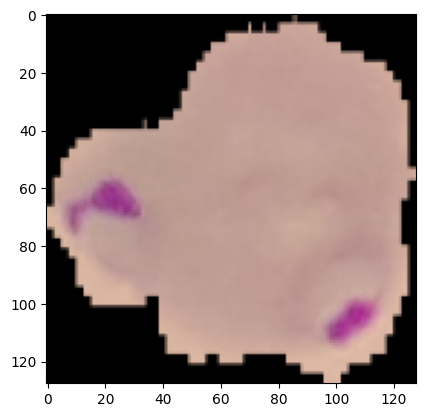

In [29]:
#show image
img = img_batch[np.where((label_batch == label_picker.value) & (predicted_classes == pred_picker.value))[0][6]]
plt.imshow(img)

In [12]:
import plotly.express as px
import skimage as sk

import numpy as np
fig = px.imshow(img)
fig.show()

In [30]:
from sklearn.datasets import make_blobs
from sklearn import mixture

v_I = np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))

NMAX = 5
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(v_I)
    bic.append(gmm.bic(v_I))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm_win = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(v_I)

[385043.140725693]
[385043.140725693, 83452.19471884325]
[385043.140725693, 83452.19471884325, 26388.518047958343]
[385043.140725693, 83452.19471884325, 26388.518047958343, 18987.71020783814]
[385043.140725693, 83452.19471884325, 26388.518047958343, 18987.71020783814, 9527.714036473086]
...and the winner is GMM model G = 5


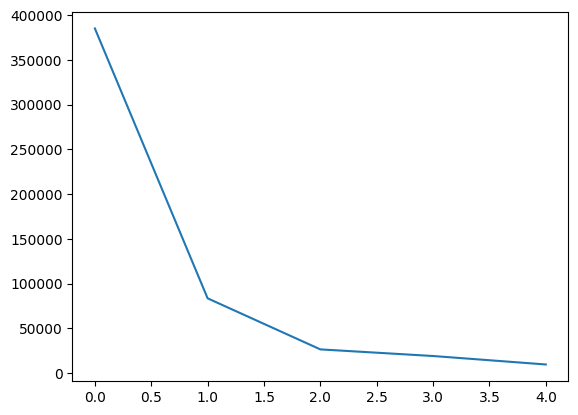

In [31]:
plt.plot(bic)


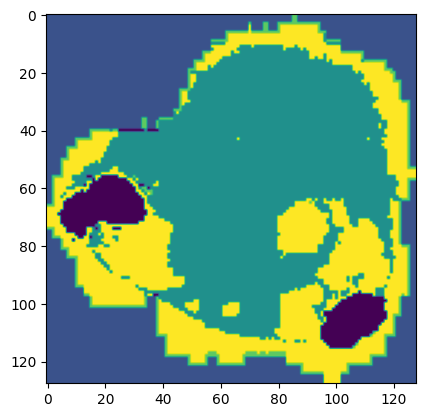

In [32]:
v_I_gmm = gmm_win.predict(v_I)

I_gmm = np.reshape(v_I_gmm,[img.shape[0],img.shape[1]])

plt.imshow(I_gmm)

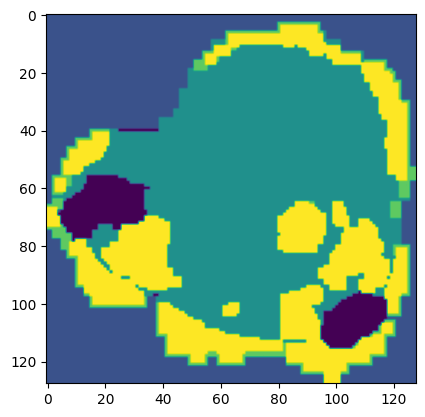

In [33]:
from skimage.morphology import opening, square
opened = opening(I_gmm, square(4))
plt.imshow(opened)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

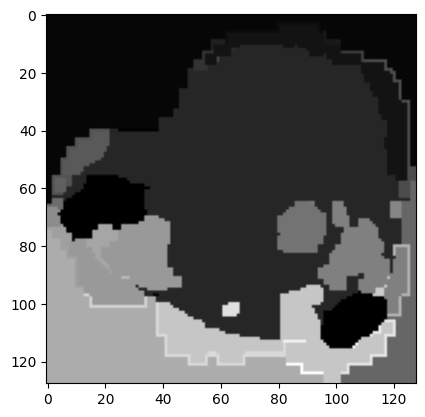

In [34]:
labeled = measure.label(opened)
plt.imshow(labeled, cmap='gray')
np.unique(labeled)

In [18]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model, pred_index = 0)

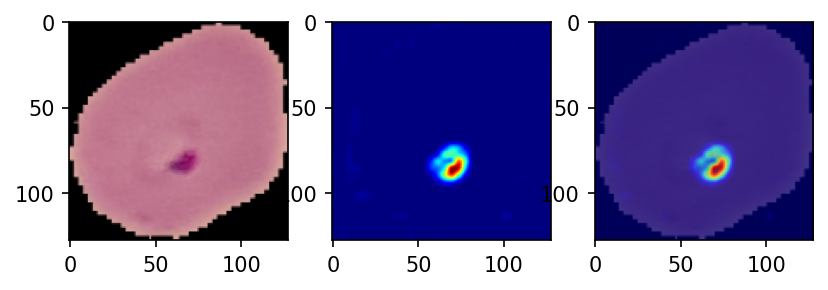

In [19]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')


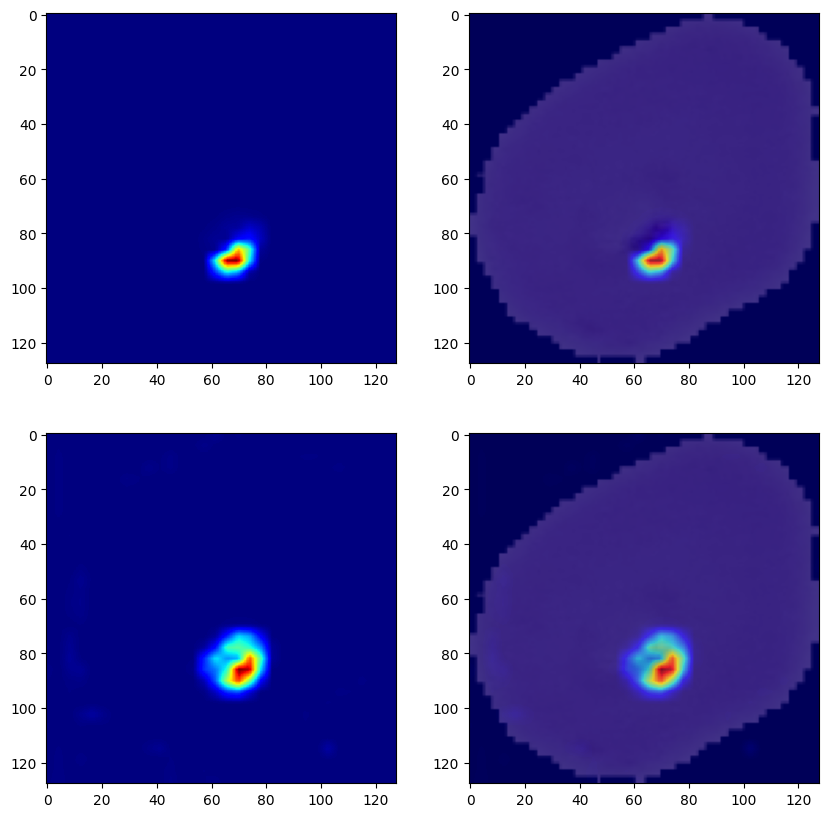

In [20]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(0), img.astype('float32')).squeeze()
cam2 = gradcam2(CategoricalScore(0), img.astype('float32')).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


4/4 [==============================] - 0s 7ms/step


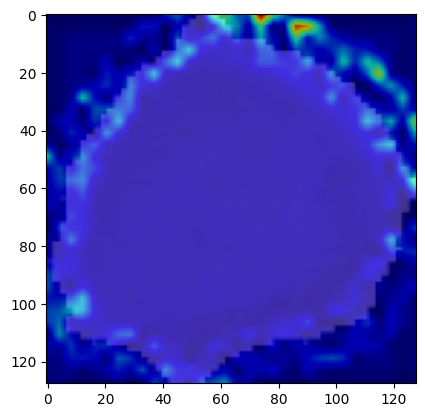

In [72]:
from tf_keras_vis.scorecam import Scorecam

scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)